<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [26]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.utils import resample

from warnings import filterwarnings

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#increase display rows
pd.options.display.max_rows = 200

# reduce the warnings
filterwarnings('ignore')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv', index_col='Id')
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [3]:
# Limit dataset to be Residential only
df = house[house['MSZoning'].str.contains('R')
           | house['MSZoning'].str.contains('FV')]

# Check which columns have null values
count = 0
print('Variable : Number of null values')
for col in df.columns:
    if df[col].isnull().sum() != 0:
        print(col, ' : ', df[col].isnull().sum())
        count += 1

print('\nTotal number of variables with null values:', count)

Variable : Number of null values
LotFrontage  :  259
Alley  :  1361
MasVnrType  :  8
MasVnrArea  :  8
BsmtQual  :  37
BsmtCond  :  37
BsmtExposure  :  38
BsmtFinType1  :  37
BsmtFinType2  :  38
Electrical  :  1
FireplaceQu  :  681
GarageType  :  79
GarageYrBlt  :  79
GarageFinish  :  79
GarageQual  :  79
GarageCond  :  79
PoolQC  :  1443
Fence  :  1172
MiscFeature  :  1398

Total number of variables with null values: 19


#### <font color='blue'> EDA </font>

In [4]:
# Using mean of LotFrontage to impute missing LotFrontage values
# The mean and median values are very close (70.1 and 70.0). 
# We can assume our distribution of LotFrontage is fairly normal.
df.LotFrontage.fillna(df.LotFrontage.mean(), inplace=True)

# houses with no alley access
df.Alley.fillna('NA', inplace=True)

# houses with no masonry veneer
df.MasVnrType.fillna('None', inplace=True)
df.MasVnrArea.fillna(0.0, inplace=True)

# houses with no basement
df.BsmtQual.fillna('NA', inplace=True)
df.BsmtCond.fillna('NA', inplace=True)
df.BsmtExposure.fillna('NA', inplace=True)
df.BsmtFinType1.fillna('NA', inplace=True)
df.BsmtFinType2.fillna('NA', inplace=True)

# Dropping 1 entry where Electrical is missing
df.drop(df[df.Electrical.isnull()].index[0], inplace=True)

# houses with no fireplace
df.FireplaceQu.fillna('NA', inplace=True)

# houses with no garage
df.GarageType.fillna('NA', inplace=True)
df.GarageFinish.fillna('NA', inplace=True)
df.GarageQual.fillna('NA', inplace=True)
df.GarageCond.fillna('NA', inplace=True)
df.GarageYrBlt.fillna('NA', inplace=True)

# houses with no pool
df.PoolQC.fillna('NA', inplace=True)

# houses with no fence
df.Fence.fillna('NA', inplace=True)

# houses with no Miscellaneous features
df.MiscFeature.fillna('NA', inplace=True)

In [5]:
#Reset index after dropping na entries from Electrical column
df.reset_index(inplace = True)
df.drop(columns='Id', inplace = True)

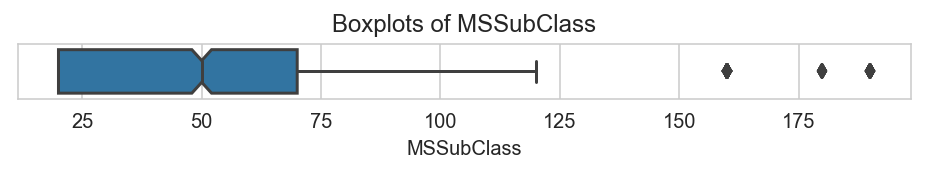

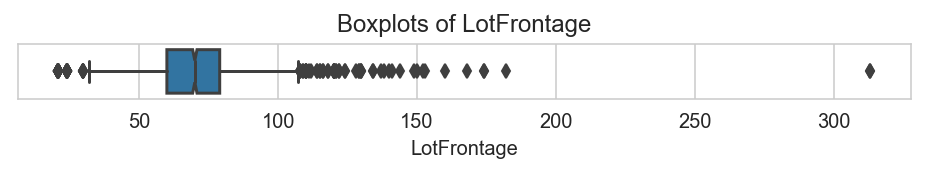

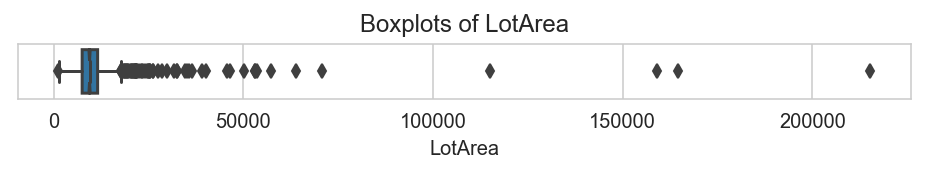

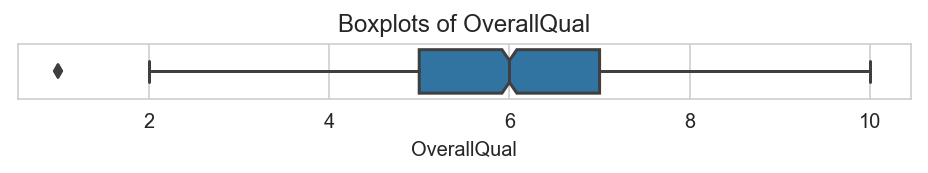

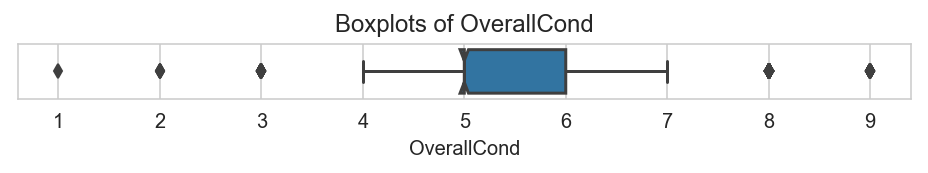

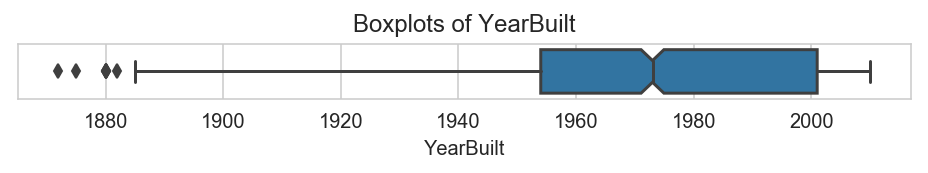

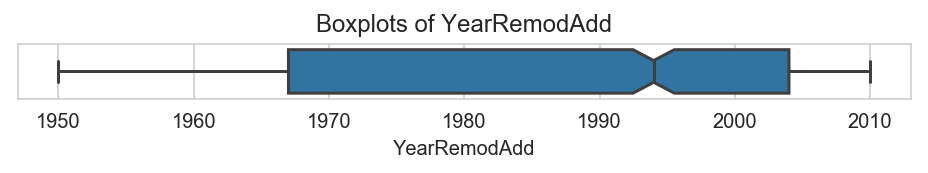

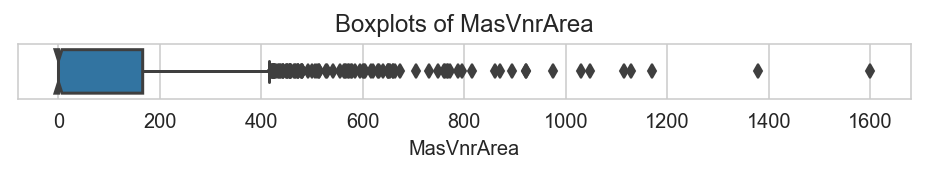

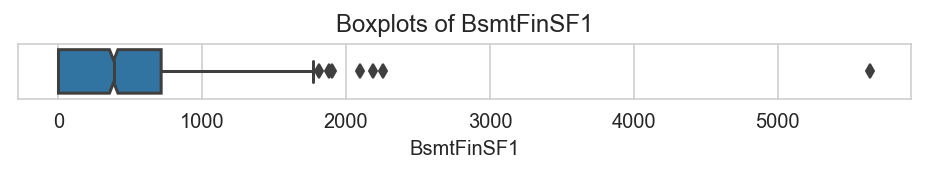

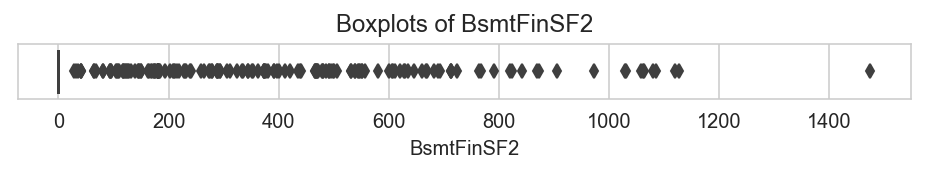

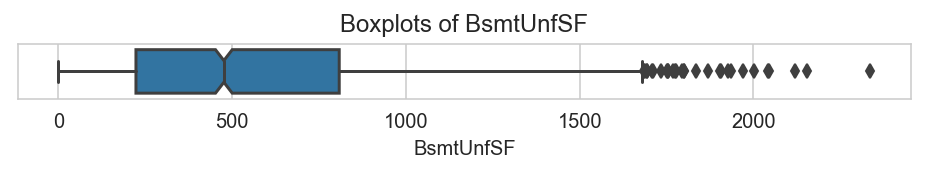

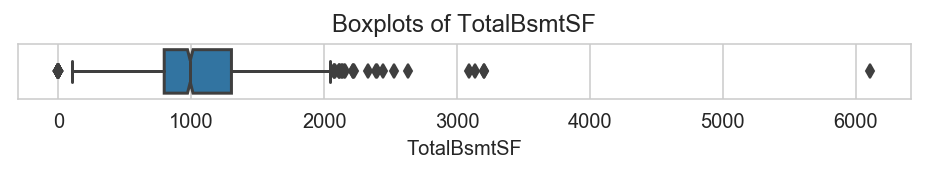

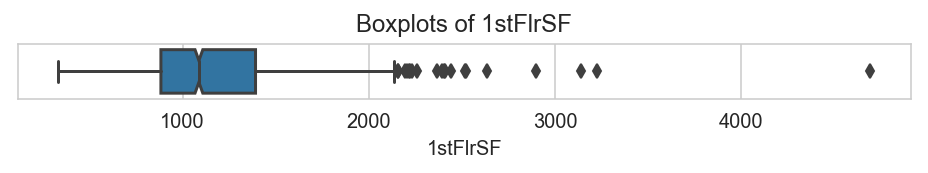

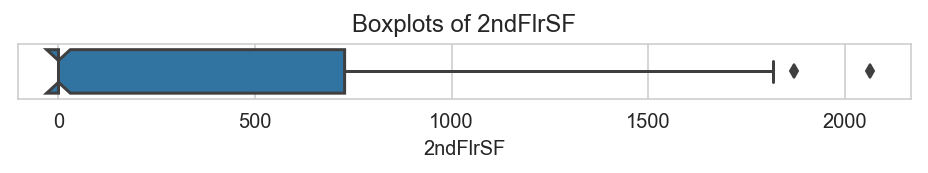

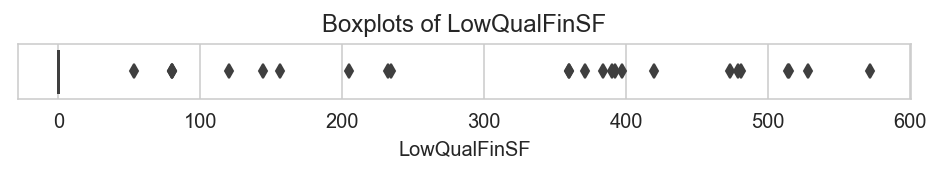

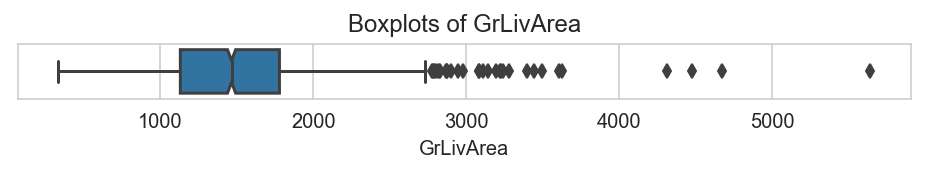

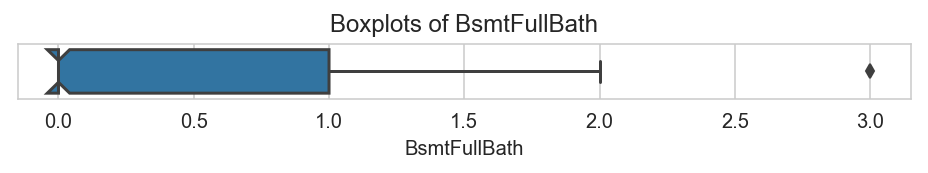

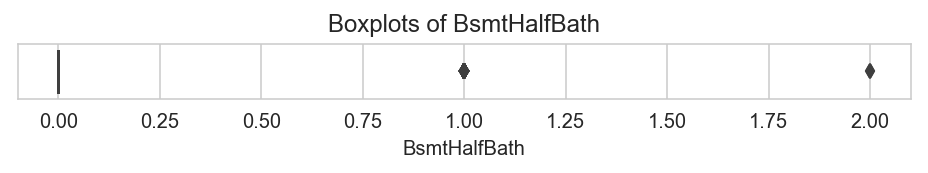

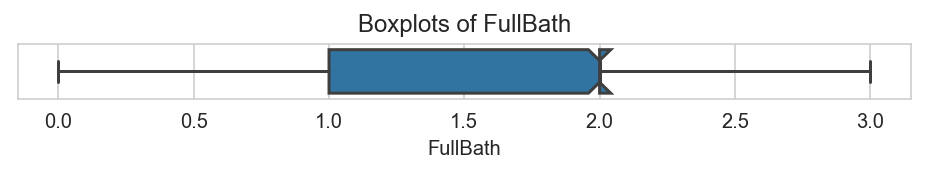

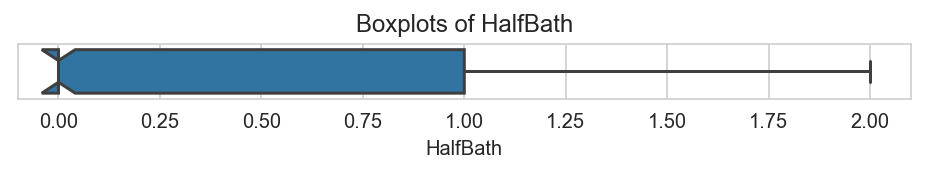

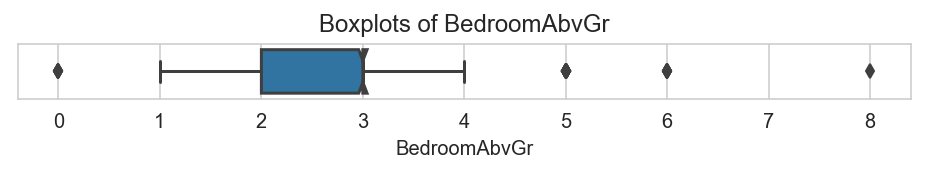

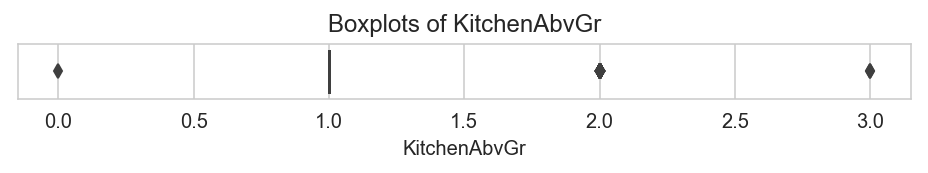

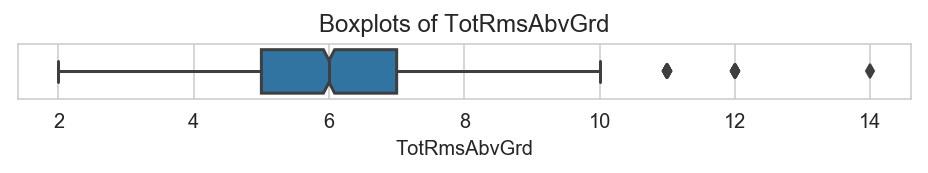

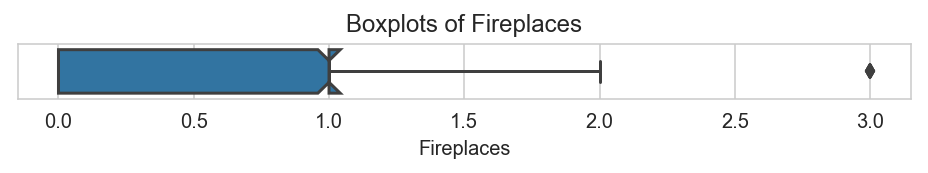

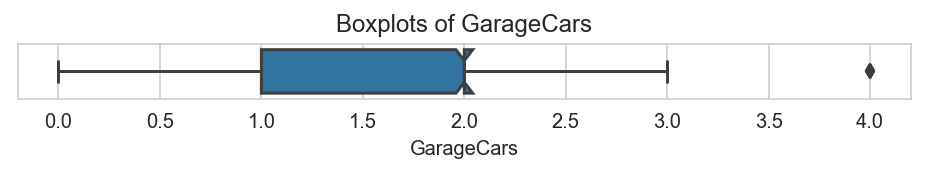

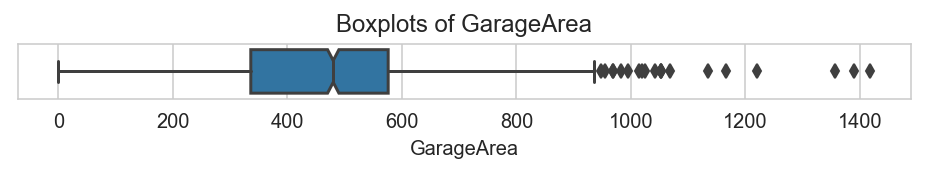

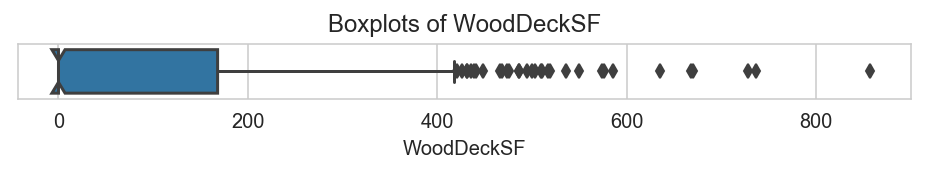

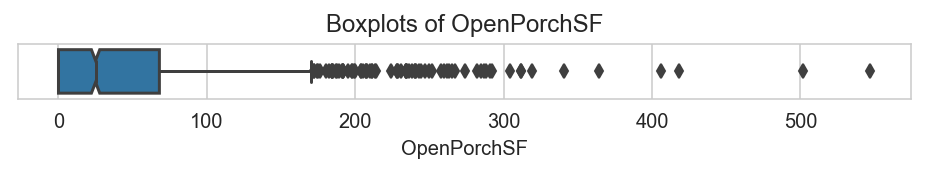

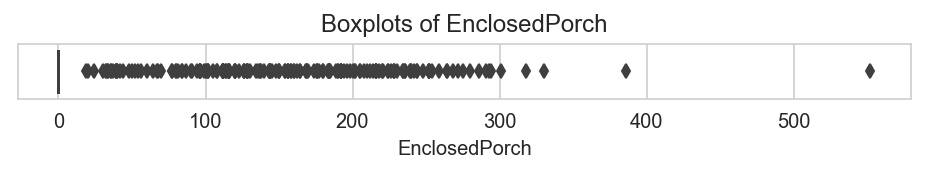

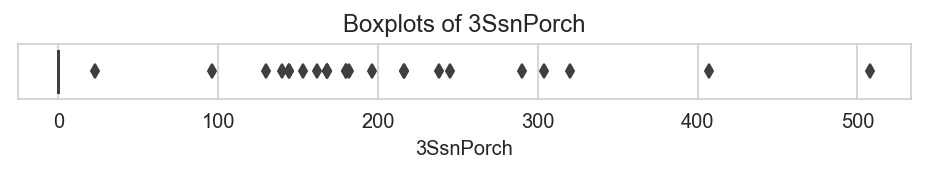

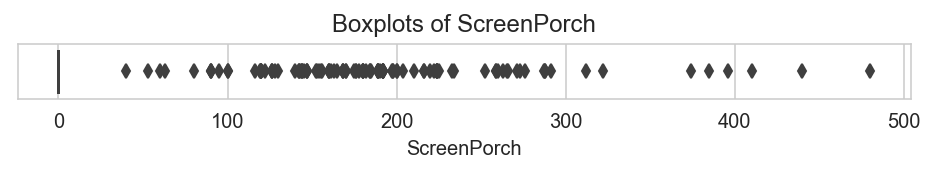

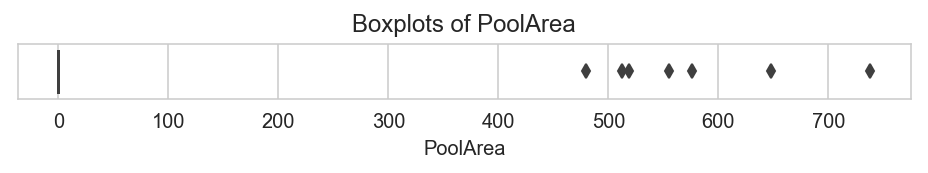

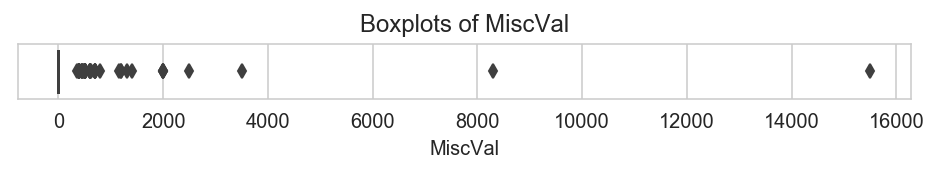

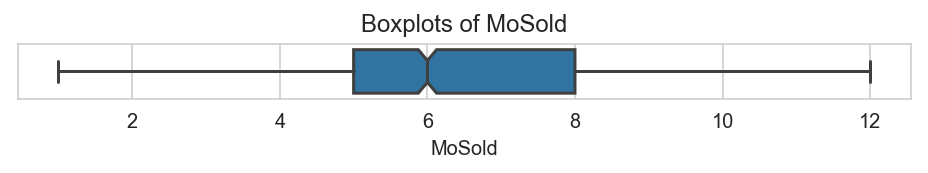

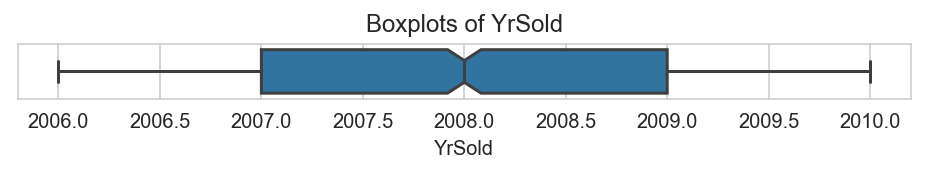

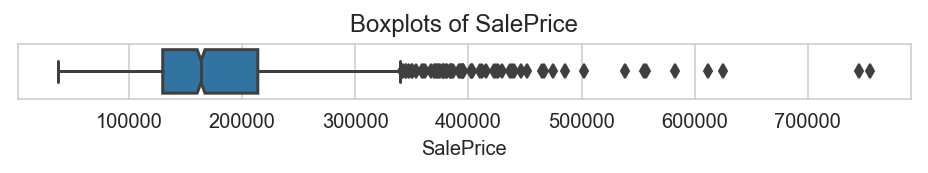

In [6]:
# histograms of the non-object variables after some data cleaning:
for col in df.columns:
    if df[col].dtypes != object:
        plt.figure(figsize = (8, 0.5))
        sns.boxplot(df[col], notch = True)
        plt.title('Boxplots of ' + col)
        plt.show()

<font color='blue'> From the histograms above, it can be observed that some columns are not normally distributed and have outliers.</font> 

In [7]:
#to examine which predictors are highly correlated with Sale price
df.corr()['SalePrice'].sort_values(ascending=False).head()

SalePrice      1.000000
OverallQual    0.789119
GrLivArea      0.708650
GarageCars     0.642201
GarageArea     0.629822
Name: SalePrice, dtype: float64

<font color='blue'> From the correlation results above, it can be observed that GrLivArea and GarageCars (both which are fixed and not easily renovate-able) has a relatively high positive correlation with Sale price. It may be one of the important predictors for sale price. </font>

<font color='blue'> Using the top 3 predictors identified above, the 3 plots below shows the positive correlation with Sale price. </font>

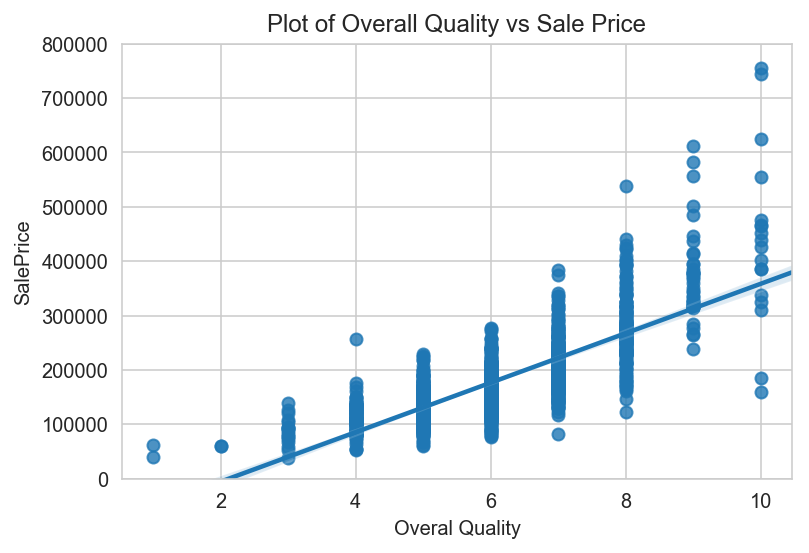

In [8]:
sns.regplot(df['OverallQual'],df['SalePrice'])
plt.title('Plot of Overall Quality vs Sale Price')
plt.ylim([0, 800000])
plt.xlabel('Overal Quality');

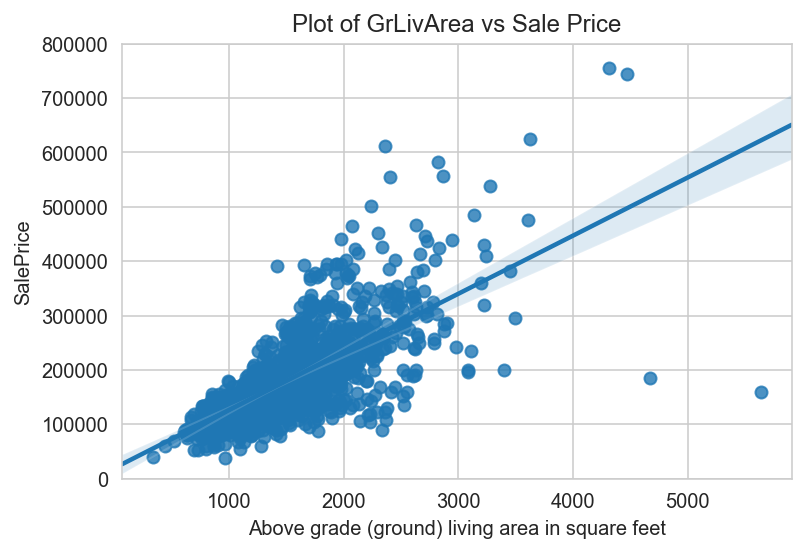

In [9]:
sns.regplot(df['GrLivArea'],df['SalePrice'])
plt.title('Plot of GrLivArea vs Sale Price')
plt.ylim([0, 800000])
plt.xlabel('Above grade (ground) living area in square feet');

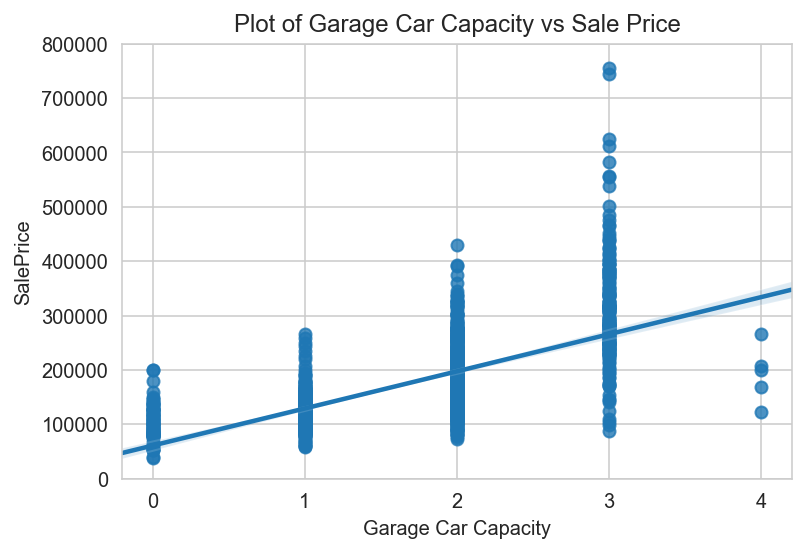

In [10]:
sns.regplot(df['GarageCars'],df['SalePrice'])
plt.title('Plot of Garage Car Capacity vs Sale Price')
plt.xlabel('Garage Car Capacity')
plt.xticks(ticks=[0,1,2,3,4],labels=[0,1,2,3,4])
plt.ylim([0, 800000]);

In [11]:
# Further data cleaning

# Some strange entries with No masonry veneer type, and yet has masonry veneer area
print(df[(df.MasVnrType == 'None') & (df.MasVnrArea != 0.0)
         ].loc[:, ['MasVnrType', 'MasVnrArea']])

df.loc[[625, 774, 1231, 1301, 1335], 'MasVnrArea'] = 0.0

     MasVnrType  MasVnrArea
619        None       288.0
767        None         1.0
1221       None         1.0
1290       None       344.0
1324       None       312.0


In [12]:
# Some strange entries with masonry veneer type, and yet no masonry veneer area
print(df[(df.MasVnrType != 'None') & (df.MasVnrArea == 0.0)
         ].loc[:, ['MasVnrType', 'MasVnrArea']])

df.loc[[689, 1242], 'MasVnrType'] = 'None'

     MasVnrType  MasVnrArea
683     BrkFace         0.0
774     BrkFace         0.0
1231    BrkFace         0.0
1232      Stone         0.0
1301    BrkFace         0.0


In [13]:
# Strange entry where there is an unfinished basement, yet BsmtExposure states no basement.
print(df[(df.BsmtExposure == 'NA') & (df.BsmtCond != 'NA')]
      .loc[:, 'BsmtQual':'TotalBsmtSF'])

# Amending entry to 'No' exposure instead
df.loc[949, 'BsmtExposure'] = 'No'

    BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  \
940       Gd       TA           NA          Unf           0          Unf   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  
940           0        936          936  


In [14]:
# Strange entries where there is $0 value of miscellaneous feature yet
# miscellaneous feature was recorded. No valuation for the miscellaneous features.
# No data amendment done
df[(df.MiscFeature != 'NA') & (df.MiscVal == 0)].loc[:, 'MiscFeature':'MiscVal']

,MiscFeature,MiscVal
866,Othr,0
1191,Shed,0


In [15]:
# Cast MSSubClass as categorical variable
df['MSSubClass'] = df['MSSubClass'].astype(object)

#### <font color='blue'> Preliminary feature selection </font>

In [16]:
# choosing which predictors are fixed, which are renovate-able and which are not used
X_fix_col = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
             'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
             'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
             'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
             'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
             '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
             'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
             'GarageType', 'GarageCars', 'GarageArea', 'PavedDrive', 'WoodDeckSF',
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
             'MiscFeature', 'MiscVal']
X_reno_col = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
              'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
              'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF',
              'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
              'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'BsmtCond']

# Time related data (i.e. Yr built, YrRemodAdd, GarageYrBlt) is not relevant as quality 
# and condition is more important to estimate price of the property.

# YrSold, MoSold, SaleType, SaleCondition is characteristics of the sale transaction and
# does not belong to either categories. In addition, these parameters won't be available 
# when predicting the property price as the property has not been sold at the point when
# the model is being used to predict the price.

X_notused = ['GarageYrBlt', 'YearRemodAdd', 'YearBuilt',
             'MoSold', 'YrSold', 'SaleType', 'SaleCondition']

# Reduce to dataframe of relevant predictors only
Xf = df[X_fix_col]

# convert categorical variables into binary variables
X = pd.DataFrame()
for col in Xf.columns:
    if Xf[col].dtype == object:
        X = pd.concat(
            [X, pd.get_dummies(Xf[col], prefix=col, drop_first=True)], axis=1)
    else:
        X = pd.concat([X, Xf[col]], axis=1)

# split data into pre2010 and 2010 for training and testing respectively

y1_train = df[df['YrSold'] != 2010]['SalePrice']
y1_test = df[df['YrSold'] == 2010]['SalePrice']
X1_train = X[df['YrSold'] != 2010]
X1_test = X[df['YrSold'] == 2010]

#### <font color='blue'> Model fitting </font>

In [17]:
def regressionfunction(X_train, X_test, y_train, y_test):
    '''Function to do StandardScaler scaling.
    LinearRegression is used to establish the baseline,
    while Lasso + RFECV is used for feature selection'''

    # Standard Scaler function to scale X
    ss = StandardScaler()
    Xs_train = ss.fit_transform(X_train)
    Xs_test = ss.transform(X_test)

    # Linear Regression
    lr = LinearRegression()
    model = lr.fit(Xs_train, y_train)
    y_pred = model.predict(Xs_test)
    print('=====Linear Regression======')
    print('Root Mean Square Error: ', round(np.sqrt(
        metrics.mean_squared_error(y_test, y_pred)), 2))
    print('R2 Score: ', round(model.score(Xs_test, y_test), 2))

    # Lasso regression + RFECV for feature selection
    alpha_range = 10**np.linspace(-1, 5, 10)
    opt_alpha = 0
    mse = 999999  # any large number, objective function is to minimise root mean square error

    for alpha in alpha_range:
        selector = RFECV(Lasso(alpha=alpha), step=1, cv=5, n_jobs=-1)
        selector.fit(Xs_train, y_train)
        y_pred = selector.predict(Xs_test)

        if np.sqrt(metrics.mean_squared_error(y_test, y_pred)) < mse:
            mse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
            opt_alpha = alpha
            opt_support = selector.support_

    # best model chosen based on Lasso + RFECV
    opt_model = Lasso(alpha=opt_alpha)
    opt_model.fit(Xs_train, y_train)
    print('========Lasso + RFECV========')
    print('Optimum alpha: {} Root Mean Square Error: {} R2 score:{}'.format(
        opt_alpha, round(mse, 2), round(opt_model.score(Xs_test, y_test), 2)))
    print('Intercept: ', opt_model.intercept_)

    coef_vars = pd.DataFrame({
        'variable': X_train.columns,
        'coef': opt_model.coef_,
        'abscoef': np.abs(opt_model.coef_),
        'chosenbyRFECV': opt_support
    })

    coef_vars.sort_values(['chosenbyRFECV', 'abscoef'],
                          ascending=False, inplace=True)

    print(coef_vars[coef_vars['chosenbyRFECV']==True])

    return None

regressionfunction(X1_train, X1_test, y1_train, y1_test)

=====Linear Regression======
Root Mean Square Error:  28729.07
R2 Score:  0.87
========Lasso + RFECV========
Optimum alpha: 2.1544346900318834 Root Mean Square Error: 27998.15 R2 score:0.87
Intercept:  182001.1292090838
                 variable          coef       abscoef  chosenbyRFECV
91            BsmtQual_Gd -21593.205508  21593.205508           True
93            BsmtQual_TA -20863.043805  20863.043805           True
115              2ndFlrSF  18937.168187  18937.168187           True
116             GrLivArea  16195.587871  16195.587871           True
125     GarageType_Attchd  15161.065505  15161.065505           True
129     GarageType_Detchd  13446.025968  13446.025968           True
50   Neighborhood_NridgHt  11099.396828  11099.396828           True
79      HouseStyle_1Story  10749.923142  10749.923142           True
131            GarageCars  10684.691416  10684.691416           True
130         GarageType_NA   9551.656824   9551.656824           True
49   Neighborhood_NoR

<font color='blue'> Comparing Linear Regression versus Lasso+RFECV, both had similar root mean square errors of 2.8 x $10^{4}$ and R2 Score of 0.87. The initial list of best predictors is as follows:

     'BsmtQual', '2ndFlrSF', 'GrLivArea', 'GarageType', 'Neighborhood',
     'HouseStyle', 'GarageCars', 'LotArea', '1stFlrSF', 'KitchenAbvGr',
     'FullBath', 'Condition2', 'BedroomAbvGr', 'TotRmsAbvGrd', 'BsmtExposure',
     'Foundation', 'BsmtFinType1', 'LotFrontage', 'Fireplaces', 'HalfBath',
     'ScreenPorch', 'LandContour', 'TotalBsmtSF', 'BsmtFinType2', 'LandSlope',
     'LotShape', 'LotConfig', 'BldgType', 'MSSubClass', 'Condition1'
</font>

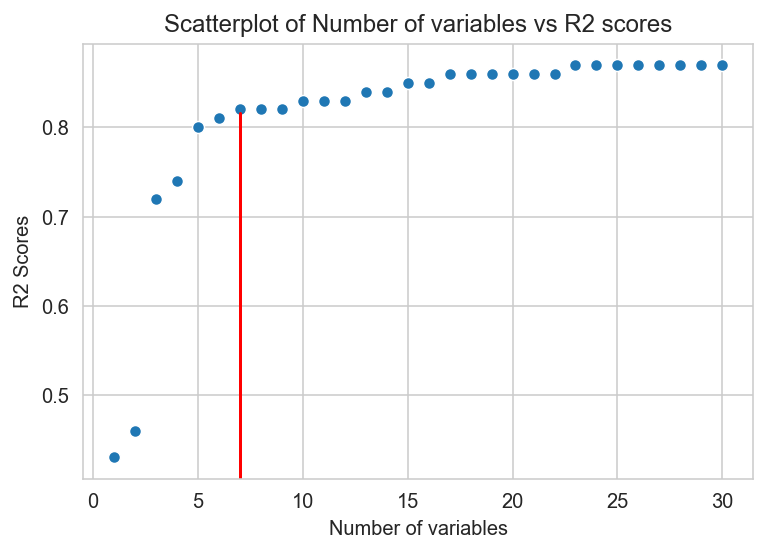

In [18]:
# to find tradeoff between top number of best variables to keep versus R2 score

X_fix_col_reduced = ['BsmtQual', '2ndFlrSF', 'GrLivArea', 'GarageType', 'Neighborhood',
                     'HouseStyle', 'GarageCars', 'LotArea', '1stFlrSF', 'KitchenAbvGr',
                     'FullBath', 'Condition2', 'BedroomAbvGr', 'TotRmsAbvGrd', 'BsmtExposure',
                     'Foundation', 'BsmtFinType1', 'LotFrontage', 'Fireplaces', 'HalfBath',
                     'ScreenPorch', 'LandContour', 'TotalBsmtSF', 'BsmtFinType2', 'LandSlope',
                     'LotShape', 'LotConfig', 'BldgType', 'MSSubClass', 'Condition1']

num_factors_to_keep = range(1, 31)
mse_list = []
score_list = []
alpha_list = []

for x in num_factors_to_keep:
    # Reduce to dataframe of relevant predictors only
    Xf_r = df[X_fix_col_reduced[0:x]]

    # convert categorical variables into binary variables
    X_r = pd.DataFrame()
    for col in Xf_r.columns:
        if Xf_r[col].dtype == object:
            X_r = pd.concat(
                [X_r, pd.get_dummies(Xf_r[col], prefix=col, drop_first=True)], axis=1)
        else:
            X_r = pd.concat([X_r, Xf_r[col]], axis=1)
    X1_r_train = X_r[df['YrSold'] != 2010]
    X1_r_test = X_r[df['YrSold'] == 2010]

    # Lasso of the reduced dataset
    alpha_range = 10**np.linspace(-3, 2, 6)
    opt_alpha = 0
    mse = 999999  # any large number, objective function is to minimise root mean square error

    ss = StandardScaler()
    Xs_train = ss.fit_transform(X1_r_train)
    Xs_test = ss.transform(X1_r_test)

    for alpha in alpha_range:
        model = Lasso(alpha=alpha)
        model.fit(Xs_train, y1_train)
        y_pred = model.predict(Xs_test)

        if np.sqrt(metrics.mean_squared_error(y1_test, y_pred)) < mse:
            mse = np.sqrt(metrics.mean_squared_error(y1_test, y_pred))
            opt_alpha = alpha

    opt_model = Lasso(alpha=opt_alpha)
    opt_model.fit(Xs_train, y1_train)

    alpha_list.append(opt_alpha)
    mse_list.append(mse)
    score_list.append(round(opt_model.score(Xs_test, y1_test), 2))

sns.scatterplot(num_factors_to_keep, score_list)
plt.axvline(x=7, ymin=0, ymax=0.84, c='r')
plt.xlabel('Number of variables')
plt.ylabel('R2 Scores')
plt.title('Scatterplot of Number of variables vs R2 scores');

<font color='blue'> From the chart above, it can be observed that the point of diminishing returns is around 7 variables. At this point the R2 score of the model is 0.82. The 7 best variables to estimate Sale price are : 'BsmtQual', '2ndFlrSF', 'GrLivArea', 'GarageType', 'Neighborhood', 'HouseStyle', 'GarageCars'. This will be used to build a model for Qn2. </font>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

#### Updated model based on 7 fixed charactistics of the property to predict Saleprice

In [19]:
Xf_r = df[X_fix_col_reduced[0:7]]

X_r = pd.DataFrame()
for col in Xf_r.columns:
    if Xf_r[col].dtype == object:
        X_r = pd.concat(
            [X_r, pd.get_dummies(Xf_r[col], prefix=col, drop_first=True)], axis=1)
    else:
        X_r = pd.concat([X_r, Xf_r[col]], axis=1)
X1_r_train = X_r[df['YrSold'] != 2010]

ss = StandardScaler()
Xs_train = ss.fit_transform(X1_r_train)
Xs = ss.transform(X_r)

opt_model = Lasso(alpha=alpha_list[6])
opt_model.fit(Xs_train, y1_train)
y_pred = opt_model.predict(Xs)


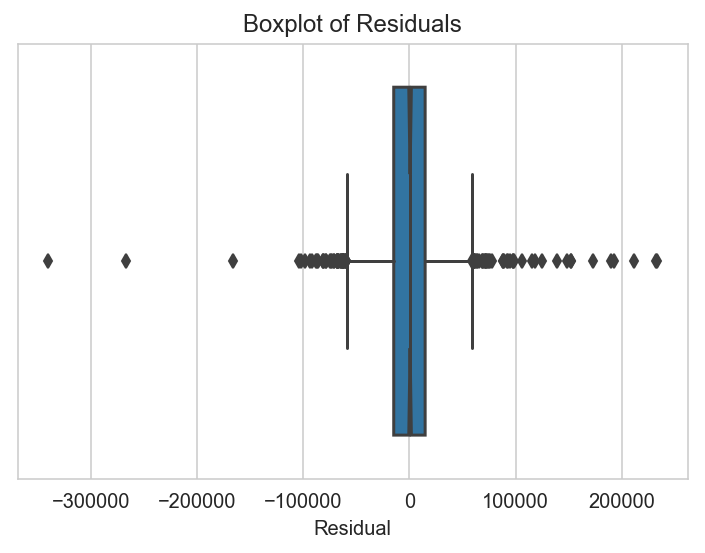

=====Linear Regression======
Root Mean Square Error:  200632366488611.84
R2 Score:  -3.540815965018125e+19
========Lasso + RFECV========
Optimum alpha: 215.44346900318823 Root Mean Square Error: 32687.58 R2 score:0.12
Intercept:  4.079808818201434e-12
      variable         coef      abscoef  chosenbyRFECV
1  OverallCond  8106.939837  8106.939837           True
0  OverallQual  4580.432192  4580.432192           True


In [20]:
# Reduce to dataframe of relevant predictors only
Xr = df[X_reno_col]

# convert categorical variables into binary variables
X2 = pd.DataFrame()
for col in Xr.columns:
    if Xr[col].dtype == object:
        X2 = pd.concat(
            [X2, pd.get_dummies(Xr[col], prefix=col, drop_first=True)], axis=1)
    else:
        X2 = pd.concat([X2, Xr[col]], axis=1)

# Create a Residual column (price of renovate-able items) to compute difference between Sale price
# and predicted price of fixed characteristics
df['Residual'] = df['SalePrice'] - y_pred

# boxplot of the Residual columns
sns.boxplot(df['Residual'], notch=True)
plt.title('Boxplot of Residuals')
plt.show()

# split data into pre2010 and 2010 for training and testing respectively
y2_train = df[df['YrSold'] != 2010]['Residual']
y2_test = df[df['YrSold'] == 2010]['Residual']
X2_train = X2[df['YrSold'] != 2010]
X2_test = X2[df['YrSold'] == 2010]

regressionfunction(X2_train, X2_test, y2_train, y2_test)

<font color='blue'> From the histogram plot of residuals, there were some outliers due to the model in qn1 being able to only account for 82% of the data. </font>

In [21]:
# to determine for every increase in 1 unit of Overall Condition, what is the delta in price
round(1/X2_train['OverallCond'].std()*8106.9398,0)

7355.0

1. Evaluate the effect in dollars of the renovate-able features.

<font color='blue'> As calculated above, for 1 unit increase in overall condition, the price of the property increases by approximately $7355. </font>

2. How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 

<font color='blue'>This second model will account for the value of the renovate-able features. If the cost to do up the renovation (e.g increase in 1 unit in overall condition) is lower than the increase in price (e.g. estimated increase in price is $7355), the company will be able to make money from this effort. </font>

3. Investigate how much of the variance in price remaining is explained by these features.

<font color='blue'>The second model has a low R2 score of 0.12, i.e it is only able to explain 12% of the residual data (variance in Sale price and predicted price of the fixed characteristics of the property).</font>

4. Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<font color='blue'>The model should not be used to evaluate which properties to buy and fix up as the model is only able to accurately predict 12% of the residuals data. </font>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [22]:
# identify which are Abnormal Sales from SaleCondition column
df['AbnormalSale'] = df['SaleCondition'].apply(lambda x: 1 if x == 'Abnorml' else 0)

baseline = df.AbnormalSale.mean()
print(baseline)

0.06625258799171843


#### <font color='blue'> Approach: </font>

<font color='blue'>

1) since the AbnormalSale column is heavily imbalanced, the training data needs to be resampled, either by up-sampling the minority class or down-sampling the majority class.

2) fit a variety of classification models with cross-validation using Stratified KFold on data:
    - logistic regression
    - k-nearest neighbour
    - random-forest

3) Use AUC to compare performance of the models using testing data

4) Based on the best performing model type, retrain model using pre 2010 data and test using 2010 data. Sort the coefficients/importance of the variables in descending order to show which variables are the important ones. 

</font>

In [23]:
def funct(X, y, sample_mode):
    '''
    Function to 
    a) split data by 5 stratified folds,
    b) resample the imbalanced data either by upsampling or downsampling,
    c) Scale the data by using StandardScaler,
    d) fit Logistic Regression, KNeighborsClassifier and RandomForestClassifier
    e) print the mean and raw AUC values
    '''

    logreg_auc = []
    rf_auc = []
    knn_auc = []

    skf = StratifiedKFold(n_splits=5)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # prepare data to do resampling
        df_combined = pd.concat([y_train, X_train], axis=1)
        df_combined.rename(columns={0: 'AbnormalSale'}, inplace=True)

        # Separate majority and minority classes
        df_majority = df_combined[df_combined['AbnormalSale'] == 0]
        df_minority = df_combined[df_combined['AbnormalSale'] == 1]

        # depends on sampling method, i.e. upsample minority or downsample majority
        if sample_mode == 'upsample':

            # Upsample minority class
            df_minority_upsampled = resample(df_minority,
                                             replace=True,     # sample with replacement
                                             # to match majority class
                                             n_samples=len(df_majority),
                                             random_state=123)  # reproducible results

            # Combine majority class with upsampled minority class
            df_resampled = pd.concat([df_majority, df_minority_upsampled])

        elif sample_mode == 'downsample':

            # downsample majority class
            df_majority_downsampled = resample(df_majority,
                                               replace=True,     # sample with replacement
                                               # to match majority class
                                               n_samples=len(df_minority),
                                               random_state=123)  # reproducible results

            # Combine majority class with downsampled majority class
            df_resampled = pd.concat([df_majority_downsampled, df_minority])

        # split to get the new resampled target and predictors
        X_train = df_resampled.drop(columns='AbnormalSale')
        y_train = df_resampled['AbnormalSale']

        # Standard Scaler to scale predictors
        ss = StandardScaler()
        Xs_train = ss.fit_transform(X_train)
        Xs_test = ss.transform(X_test)

        # Logistic Regression to get auc
        logreg = LogisticRegression()
        model_logreg = logreg.fit(Xs_train, y_train)

        yhat_pp_logreg = model_logreg.predict_proba(Xs_test)
        fpr_logreg, tpr_logreg, _ = roc_curve(y_test, yhat_pp_logreg[:, 1])
        logreg_auc.append(auc(fpr_logreg, tpr_logreg))

        # K Nearest Neighours to get auc
        knn = KNeighborsClassifier(n_neighbors=2, n_jobs=-1)
        model_knn = knn.fit(Xs_train, y_train)

        yhat_pp_knn = model_knn.predict_proba(Xs_test)
        fpr_knn, tpr_knn, _ = roc_curve(y_test, yhat_pp_knn[:, 1])
        knn_auc.append(auc(fpr_knn, tpr_knn))

        # Random Forest to get auc
        rf = RandomForestClassifier(n_estimators=10000, max_depth=2, n_jobs=-1)
        model_rf = rf.fit(Xs_train, y_train)

        yhat_pp_rf = model_rf.predict_proba(Xs_test)
        fpr_rf, tpr_rf, _ = roc_curve(y_test, yhat_pp_rf[:, 1])
        rf_auc.append(auc(fpr_rf, tpr_rf))
    
    if sample_mode == 'upsample':
        print('Resampling Mode: Upsampling Minority Class')
    else:
        print('Resampling Mode: Downsampling Majority Class')
        
    print('Logistic Regression Mean AUC:', np.round(
        np.mean(logreg_auc), 2), 'Raw AUC:', np.round(logreg_auc, 2))
    print('K Nearest Neighbour Mean AUC:', np.round(
        np.mean(knn_auc), 2), 'Raw AUC:', np.round(knn_auc, 2))
    print('Random Forest Mean AUC:', np.round(
        np.mean(rf_auc), 2), 'Raw AUC:', np.round(rf_auc, 2))
    print('\n')

    return None

In [24]:
# Reduce to dataframe of relevant predictors only
# Same rationale as before to exclude 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt',
#  'MoSold', 'YrSold', 'SaleType', 'SaleCondition' and 'SalePrice'
Xf = df[X_fix_col + X_reno_col]

# convert categorical variables into binary variables
X = pd.DataFrame()
for col in Xf.columns:
    if Xf[col].dtype == object:
        X = pd.concat(
            [X, pd.get_dummies(Xf[col], prefix=col, drop_first=True)], axis=1)
    else:
        X = pd.concat([X, Xf[col]], axis=1)

funct(X, df['AbnormalSale'], "downsample")
funct(X, df['AbnormalSale'], "upsample")

Resampling Mode: Downsampling Majority Class
Logistic Regression Mean AUC: 0.53 Raw AUC: [0.59 0.39 0.5  0.55 0.61]
K Nearest Neighbour Mean AUC: 0.52 Raw AUC: [0.52 0.41 0.57 0.5  0.57]
Random Forest Mean AUC: 0.61 Raw AUC: [0.53 0.65 0.64 0.65 0.58]


Resampling Mode: Upsampling Minority Class
Logistic Regression Mean AUC: 0.52 Raw AUC: [0.52 0.43 0.48 0.57 0.59]
K Nearest Neighbour Mean AUC: 0.51 Raw AUC: [0.49 0.46 0.55 0.57 0.49]
Random Forest Mean AUC: 0.61 Raw AUC: [0.55 0.69 0.62 0.66 0.55]




<font color='blue'> From the results above, it was observed that both downsampling and upsampling had similar AUC values (0.5 - 0.6) for the 3 models. Among the 3 models, Random Tree model had the highest mean AUC of 0.61 which is only slightly better than baseline of 0.5. </font>

In [31]:
# Fit a random forest model to determine which features are predictive of Abnormal Sales
for col in Xf.columns:
    if Xf[col].dtypes == object:
        le = preprocessing.LabelEncoder()
        Xf[col] = le.fit_transform(Xf[col])

# split data into pre2010 and 2010 for training and testing respectively
y3_train = df[df['YrSold'] != 2010]['AbnormalSale']
y3_test = df[df['YrSold'] == 2010]['AbnormalSale']
X3_train = Xf[df['YrSold'] != 2010]
X3_test = Xf[df['YrSold'] == 2010]

# prepare training data to do upsampling
df_combined = pd.concat([y3_train, X3_train], axis=1)
df_combined.rename(columns={0: 'AbnormalSale'}, inplace=True)

# Separate majority and minority classes
df_majority = df_combined[df_combined['AbnormalSale'] == 0]
df_minority = df_combined[df_combined['AbnormalSale'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 # to match majority class
                                 n_samples=len(df_majority),
                                 random_state=123)  # reproducible results

# Combine majority class with upsampled minority class
df_resampled = pd.concat([df_majority, df_minority_upsampled])

# split to get the new resampled target and predictors
X3_train = df_resampled.drop(columns='AbnormalSale')
y3_train = df_resampled['AbnormalSale']

# Random Forest to get auc
# train based on pre 2010 data
rf = RandomForestClassifier(n_estimators=10000, max_depth=2, n_jobs=-1)
model_rf = rf.fit(X3_train, y3_train)

# obtain mean precision & recall based on 2010 data
yhat = model_rf.predict(X3_test)
precision, recall, _ = precision_recall_curve(y3_test, yhat)
print('Mean precision: ', round(np.mean(precision), 2),
      ' Mean recall: ', round(np.mean(recall), 2))

impt_predictors = pd.DataFrame({
    'predictors': X3_train.columns,
    'importance': model_rf.feature_importances_})

impt_predictors.sort_values(by='importance', ascending=False).head()

Mean precision:  0.38  Mean recall:  0.56


,predictors,importance
23,BsmtUnfSF,0.099821
48,OverallQual,0.058911
38,GarageArea,0.054280
3,LotArea,0.046978
16,Foundation,0.043102


<font color='blue'> Based on Random Forest model, the top 5 predictors in order of importance is shown above. Unable to distinguish whether the predictors are postive or negative predictors of AbnormalSales as random forest doesn't consider this aspect.

Precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The mean precision is rather poor at 0.38.

Recall is intuitively the ability of the classifier to find all the positive samples. The mean precision is also rather poor at 0.56.
</font>